# Gene-to-graph workflow

This notebook showcases the steps to generate the BioDataFuse data and graph serializations from a list of genes.


In [1]:
# Import modules
import os
import pickle

import pandas as pd
from IPython.display import Image, display
from rdflib import RDF, RDFS, SH, Graph

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    aopwiki,
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.graph import generator
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.graph.rdf.graphdb import GraphDBManager
from pyBiodatafuse.graph.saver import save_graph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

## 1. Entity resolution with BridgeDB

The first step is to input the list of genes to query and retrieve their protein target and synonym identifiers using BridgeDB.

### 1.1. Load the input list and convert it to a dataframe

In [2]:
genes_of_interest = """7350
6198
1499
6528
6714
10000
10891
6194
7068
4193
3709
"""

gene_list = genes_of_interest.split("\n")
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

identifier
0       7350
1       6198
2       1499
3       6528
4       6714

### 1.2. Query BridgeDB
The results will be stored in the following directories:

In [3]:
base_dir = os.path.abspath(os.getcwd())
DATA_DIR = os.path.join(base_dir, "data")
EXAMPLE_DIR = os.path.join(DATA_DIR, "gene_to_graph_workflow")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EXAMPLE_DIR, exist_ok=True)

In [4]:
pickle_path = f"{EXAMPLE_DIR}/gene_list.pkl"
metadata_path = f"{EXAMPLE_DIR}/gene_list_metadata.pkl"

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="NCBI Gene",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [5]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 11


identifier identifier.source      target  target.source
0       7350       Entrez Gene     2787089           Affy
1       7350       Entrez Gene     8102904           Affy
2       7350       Entrez Gene     2787088           Affy
3       7350       Entrez Gene  GO:0071398  Gene Ontology
4       7350       Entrez Gene     2787087           Affy

In [6]:
aopwiki_df, aopwiki_metadata = aopwiki.get_aops(
    bridgedb_df=bridgedb_df,
    db="aopwiki",
    input_type="gene",
    input_identifier="Ensembl",
)
aopwiki_df

Querying aopwiki for gene: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


identifier identifier.source           target target.source  \
0       10000       Entrez Gene  ENSG00000117020       Ensembl   
1       10891       Entrez Gene  ENSG00000109819       Ensembl   
2        1499       Entrez Gene  ENSG00000168036       Ensembl   
3        3709       Entrez Gene  ENSG00000123104       Ensembl   
4        4193       Entrez Gene  ENSG00000135679       Ensembl   
5        6194       Entrez Gene  ENSG00000137154       Ensembl   
6        6198       Entrez Gene  ENSG00000108443       Ensembl   
7        6528       Entrez Gene  ENSG00000105641       Ensembl   
8        6714       Entrez Gene  ENSG00000197122       Ensembl   
9        7068       Entrez Gene  ENSG00000151090       Ensembl   
10       7350       Entrez Gene  ENSG00000109424       Ensembl   

                                             aop_gene  
0   [{'aop': '17', 'aop_title': 'Binding of electr...  
1   [{'aop': '17', 'aop_title': 'Binding of electr...  
2   [{'aop': '17', 'aop_title': 'Binding of electr...  
3   [{'aop': '17', 'aop_title': 'Binding of electr...  
4   [{'aop': '17', 'aop_title': 'Binding of electr...  
5   [{'aop': '17', 'aop_title': 'Binding of electr...  
6   [{'aop': '17', 'aop_title': 'Binding of electr...  
7   [{'aop': '17', 'aop_title': 'Binding of electr...  
8   [{'aop': '17', 'aop_title': 'Binding of electr...  
9   [{'aop': '17', 'aop_title': 'Binding of electr...  
10  [{'aop': '17', 'aop_title': 'Binding of electr...

## 2. Gene expression
### 2.1. Gene expression from Bgee

In [7]:
bgee_path = f"{EXAMPLE_DIR}/bgee.pkl"
bgee_metadata_path = f"{EXAMPLE_DIR}/bgee_metadata.pkl"

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

In [8]:
bgee_df.head(2)

identifier identifier.source           target target.source  \
0      10000       Entrez Gene  ENSG00000117020       Ensembl   
1      10891       Entrez Gene  ENSG00000109819       Ensembl   

                         Bgee_gene_expression_levels  
0  [{'anatomical_entity_id': 'UBERON:0000178', 'a...  
1  [{'anatomical_entity_id': 'UBERON:0000178', 'a...

## 3. Disease annotation
### 3.1. Gene to disease annotation with DisGeNET

In [9]:
import dotenv

disgenet_api_key = 'dotenv.dotenv_values(".env")["DISGENET_API_KEY"]'

In [10]:
disgenet_path = os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_disgenet.pkl")
disgenet_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_disgenet_metadata.pkl"
)

if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

In [11]:
disgenet_df.head(2)

identifier identifier.source target target.source  \
0      10000       Entrez Gene  10000     NCBI Gene   
1      10891       Entrez Gene  10891     NCBI Gene   

                                   DISGENET_diseases  
0  [{'disease_name': 'melanoma', 'HPO': 'HPO:HP:0...  
1  [{'disease_name': 'Diabetes Mellitus, Non-Insu...

### 3.2. Disease to compound annotation from OpenTargets

In [12]:
# Prepare the input to use DISGENET output as seed for OpenTargets
import pyBiodatafuse.constants as Cons

disease_mapping_df = create_harmonized_input_file(
    disgenet_df, Cons.DISGENET_DISEASE_COL, Cons.EFO, Cons.UMLS
)
disease_mapping_df.head()

identifier identifier.source       target target.source
0  UMLS_C0025202              UMLS  EFO_0000756           EFO
1  UMLS_C0376358              UMLS  EFO_0000673           EFO
2  UMLS_C0376358              UMLS  EFO_0001663           EFO
3  UMLS_C1621958              UMLS  EFO_0000519           EFO
4  UMLS_C0017636              UMLS  EFO_0000519           EFO

In [13]:
opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
    disease_mapping_df
)
opentargets_df

/var/folders/x2/1tdvwk7x2_n98kzwy7rnt3t00000gn/T/ipykernel_45784/162651091.py:1: UserWarning: There is no annotation for your input list in OpenTargets_disease_compounds.
  opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(


Empty DataFrame
Columns: []
Index: []

In [11]:
opentarget_path = f"{EXAMPLE_DIR}/opentarget_cmpd.pkl"
opentarget_metadata_path = f"{EXAMPLE_DIR}/opentarget_cmpd_metadata.pkl"

if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

>NOTE: No drugs for the diseases of interest found.

## 4. Pathways and Gene Ontology terms
### 4.1. Pathways from MINERVA

In [14]:
minerva_path = f"{EXAMPLE_DIR}/minerva.pkl"
minerva_metadata_path = f"{EXAMPLE_DIR}/minerva_metadata.pkl"

if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

In [15]:
minerva_df.head(2)

identifier identifier.source           target target.source  \
0      10000       Entrez Gene  ENSG00000117020       Ensembl   
1      10891       Entrez Gene  ENSG00000109819       Ensembl   

                                    MINERVA_pathways  
0  [{'pathway_id': nan, 'pathway_label': nan, 'pa...  
1  [{'pathway_id': nan, 'pathway_label': nan, 'pa...

### 4.2. Pathways from WikiPathways

In [16]:
wikipathways_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_wikipathway.pkl"
)
wikipathways_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_wikipathway_metadata.pkl"
)


if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

In [17]:
wikipathways_molecular_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_molecular_wikipathway.pkl"
)
wikipathways_molecular_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_wikipathway_molecular_metadata.pkl"
)
if not os.path.exists(wikipathways_molecular_path):
    wikipathways_molecular_df, wikipathways_molecular_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df, query_interactions=True
    )
    wikipathways_molecular_df.to_pickle(wikipathways_molecular_path)
    with open(wikipathways_molecular_metadata_path, "wb") as file:
        pickle.dump(wikipathways_molecular_metadata, file)
else:
    wikipathways_molecular_df = pd.read_pickle(wikipathways_molecular_path)
    with open(wikipathways_molecular_metadata_path, "rb") as file:
        wikipathways_molecular_metadata = pickle.load(file)

### 4.3. Reactome pathways from OpenTargets

In [18]:
opentargets_reactome_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_ot_reactome.pkl"
)
opentargets_reactome_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_ot_reactome_metadata.pkl"
)


if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

### 4.4. Gene Ontology from OpenTargets

In [19]:
opentargets_go_path = os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_ot_go.pkl")
opentargets_go_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_ot_go_metadata.pkl"
)


if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

### 4.5. Adverse Outcome Pathways from AOP-Wiki RDF

In [20]:
aopwiki_path = os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_aopwiki.pkl")
aopwiki_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_aopwiki_metadata.pkl"
)

if not os.path.exists(aopwiki_path):
    aopwiki_df, aopwiki_metadata = aopwiki.get_aops(
        bridgedb_df=bridgedb_df,
        db="aopwiki",
        input_type="gene",
        input_identifier="Ensembl",
    )
    aopwiki_df.to_pickle(aopwiki_path)
    with open(aopwiki_metadata_path, "wb") as file:
        pickle.dump(aopwiki_metadata, file)
else:
    aopwiki_df = pd.read_pickle(aopwiki_path)
    with open(aopwiki_metadata_path, "rb") as file:
        aopwiki_metadata = pickle.load(file)

## 5. Compound annotation
### 5.1. Compound annotation from OpenTargets

In [21]:
opentargets_gene_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "opentargets_gene_cmpd.pkl"
)
opentargets_gene_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "opentargets_gene_cmpd_metadata.pkl"
)

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### 4.3. Reactome pathways from OpenTargets

In [22]:
opentargets_reactome_path = f"{EXAMPLE_DIR}/opentargets_reactome.pkl"
opentargets_reactome_metadata_path = f"{EXAMPLE_DIR}/opentargets_reactome_metadata.pkl"


if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

### 4.4. Gene Ontology from OpenTargets

In [23]:
opentargets_go_path = f"{EXAMPLE_DIR}/opentargets_go.pkl"
opentargets_go_metadata_path = f"{EXAMPLE_DIR}/opentargets_go_metadata.pkl"

if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

In [24]:
opentargets_go_df.head(2)

identifier identifier.source           target target.source  \
0      10000       Entrez Gene  ENSG00000117020       Ensembl   
1      10891       Entrez Gene  ENSG00000109819       Ensembl   

                                      OpenTargets_go  
0  [{'go_id': 'GO:0005524', 'go_name': 'ATP bindi...  
1  [{'go_id': 'GO:0022904', 'go_name': 'respirato...

## 5. Compound annotation
### 5.1. Compound annotation from OpenTargets

In [25]:
opentargets_gene_path = f"{EXAMPLE_DIR}/opentargets_gene_cmpd.pkl"
opentargets_gene_metadata_path = f"{EXAMPLE_DIR}/opentargets_gene_cmpd_metadata.pkl"

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### 5.2. Screening results of compounds on proteins encoded by genes annotation by PubChem

In [26]:
pubchem_path = os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_pubchem.pkl")
pubchem_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_pubchem_metadata.pkl"
)

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

## 6. Membrane transport annotations
### 6.1 Transporter inhibitor annotation from MolMeDB

In [27]:
molmedb_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_molmedb_gene_cmpd.pkl"
)
molmedb_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_molmedb_gene_cmpd_metadata.pkl"
)

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)

## 7. Protein-Protein Interactions

### 7.1. Protein-Protein Interactions from STRING

In [28]:
string_path = os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_string.pkl")
string_metadata_path = os.path.join(
    base_dir, "data", "gene_to_graph_workflow", "example_string_metadata.pkl"
)

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

## 8. Graph generation 

### 8.1. Combine all data and metadata

In [29]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
        aopwiki_df,
        wikipathways_molecular_df,
    ],
)

In [30]:
opentargets_compound_df.head(2)

Empty DataFrame
Columns: []
Index: []

### 5.2. Screening results of compounds on proteins encoded by genes annotation by PubChem

In [31]:
pubchem_path = f"{EXAMPLE_DIR}/pubchem.pkl"
pubchem_metadata_path = f"{EXAMPLE_DIR}/pubchem_metadata.pkl"

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

In [32]:
pubchem_assay_df.head(2)

identifier identifier.source      target   target.source  \
0      10000       Entrez Gene  A0A5F9ZGY0  Uniprot-TrEMBL   
1      10000       Entrez Gene  A0A5F9ZGZ4  Uniprot-TrEMBL   

                                      PubChem_assays  
0  [{'pubchem_assay_id': nan, 'assay_type': nan, ...  
1  [{'pubchem_assay_id': nan, 'assay_type': nan, ...

## 6. Membrane transport annotations
### 6.1 Transporter inhibitor annotation from MolMeDB

In [33]:
molmedb_path = f"{EXAMPLE_DIR}/molmedb_gene_cmpd.pkl"
molmedb_metadata_path = f"{EXAMPLE_DIR}/molmedb_gene_cmpd_metadata.pkl"

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)

> NOTE: No annotations found here

## 7. Protein-Protein Interactions

### 7.1. Protein-Protein Interactions from STRING

In [34]:
string_path = f"{EXAMPLE_DIR}/string.pkl"
string_metadata_path = f"{EXAMPLE_DIR}/string_metadata.pkl"

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

In [35]:
ppi_df.head(2)

Empty DataFrame
Columns: []
Index: []

> NOTE: No interactions found here

## 8. Graph generation 

### 8.1. Combine all data and metadata

In [36]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
        wikipathways_molecular_df,
    ],
)
combined_df.to_pickle(f"{EXAMPLE_DIR}/combined_df.pkl")

In [37]:
combined_df.head(2)

identifier identifier.source           target target.source  \
0       7350       Entrez Gene  ENSG00000109424       Ensembl   
1       6198       Entrez Gene  ENSG00000108443       Ensembl   

                         Bgee_gene_expression_levels  \
0  [{'anatomical_entity_id': 'UBERON:0000955', 'a...   
1  [{'anatomical_entity_id': 'UBERON:0000178', 'a...   

                                   DISGENET_diseases  \
0  [{'disease_name': 'Obesity', 'HPO': 'HPO:HP:00...   
1  [{'disease_name': 'Colorectal Carcinoma', 'HPO...   

                                    MINERVA_pathways  \
0  [{'pathway_id': nan, 'pathway_label': nan, 'pa...   
1  [{'pathway_id': 'MINERVA:939', 'pathway_label'...   

                                WikiPathways_pathway  \
0  [{'pathway_id': 'WP:WP3407', 'pathway_label': ...   
1  [{'pathway_id': 'WP:WP5434', 'pathway_label': ...   

                                OpenTargets_reactome  \
0  [{'pathway_label': 'Mitochondrial Uncoupling',...   
1  [{'pathway_label': 'mTORC1-mediated signalling...   

                                      OpenTargets_go  \
0  [{'go_id': 'GO:1990542', 'go_name': 'mitochond...   
1  [{'go_id': 'GO:0005739', 'go_name': 'mitochond...   

                                      PubChem_assays  \
0  [{'pubchem_assay_id': nan, 'assay_type': nan, ...   
1  [{'pubchem_assay_id': nan, 'assay_type': nan, ...   

                              WikiPathways_molecular  
0  [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
1  [{'pathway_id': 'WP:4746', 'pathway_label': 'T...

The following code chunk shuffles the DisGeNET-queried data before serializing the graphs and displaying them, as it is not open access.

In [38]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

In [39]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
        aopwiki_metadata,
        wikipathways_molecular_metadata,
    ],
)

We export the combined (meta) data in pickle format:

In [40]:
combined_df.to_pickle(
    os.path.join(base_dir, "data", "gene_to_graph_workflow", "example_df_shuffled.pkl")
)
with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

with open("opentargets_disease_compound_df.pkl", "wb") as out:
    pickle.dump(opentargets_metadata, out)

### 8.2. Create a graph from the annotated dataframe

In [41]:
pygraph = save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir=EXAMPLE_DIR,
)

Combined DataFrame saved in /home/javi/pybdf/pyBiodatafuse/examples/data/gene_to_graph_workflow/examples_df.pkl
Metadata saved in /home/javi/pybdf/pyBiodatafuse/examples/data/gene_to_graph_workflow/examples_metadata.pkl
Building graph: 100%|██████████| 78/78 [00:02<00:00, 32.04it/s]
Graph is built successfully
Graph saved in /home/javi/pybdf/pyBiodatafuse/examples/data/gene_to_graph_workflow/examples_graph.pkl and /home/javi/pybdf/pyBiodatafuse/examples/data/gene_to_graph_workflow/examples_graph.gml
Graph saved in /home/javi/pybdf/pyBiodatafuse/examples/data/gene_to_graph_workflow/examples_graph.edgelist


#### 8.3. Cytoscape
Make sure that the Cytoscape is open.

In [42]:
import logging

import py4cytoscape as p4c

from pyBiodatafuse.graph import cytoscape

# Disable all logging for py4cytoscape
logging.disable(logging.CRITICAL)  # Disable all logging
cytoscape.load_graph(pygraph, network_name="Test network")  # Load the graph into Cytoscape

Applying default style...
Applying preferred layout


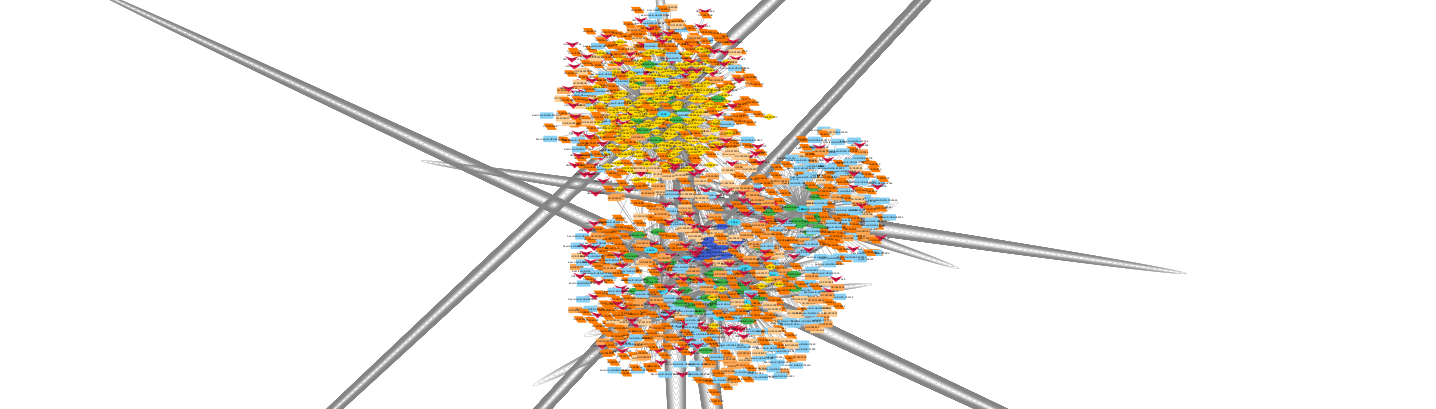

In [43]:
import py4cytoscape as p4c

p4c.notebook_export_show_image()

#### 8.4. Neo4j

In [44]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

#### 8.5. RDF

In [45]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

Building RDF graph: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]


In [46]:
bdf.serialize(
    os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_graph.ttl",
    ),
    format="ttl",
)

<Graph identifier=N129b13513fa042d68438bad2855fbf26 (<class 'pyBiodatafuse.graph.rdf.rdf.BDFGraph'>)>

##### 8.5.1. Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [47]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow",
        "gene_to_graph_workflow",
        "BDF_prefixes.ttl",
    ),
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "http://www.w3.org/ns/dcat#"^^xsd:anyURI ;
            sh:prefix "dcat" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/onto/bdf#"^^xsd:anyURI ;
            sh:prefix "bdfo" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/life_cycle"^^xsd:anyURI ;
            sh:prefix "life_cycle_base_node" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene_disease_association"^^xsd:anyURI ;
            sh:prefix "gene_disease_association" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2004/02/skos/core#"^^xsd:anyURI ;
            sh:prefix "skos" ] .

[] sh:declare [ sh:namespace "http://purl.obolibrary.org/obo/"^^xsd:anyURI ;
            sh:prefix "obo" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/experimental_process"^^xsd:anyURI ;
            sh:prefix "experimental_process_node" ] .

[] sh:declar

<Graph identifier=N38b01510ffe64fbeb00288ce44cce529 (<class 'rdflib.graph.Graph'>)>

##### 8.5.2. Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in SHACL (https://www.w3.org/TR/shacl/) and ShEx (https://shex.io/shex-semantics/).

- **SHACL**

@prefix : <http://weso.es/shapes/> .
@prefix bdfo: <https://biodatafuse.org/onto/bdf#> .
@prefix interaction: <https://biodatafuse.org/example/interaction> .
@prefix ns1: <http://vocabularies.wikipathways.org/wp#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:DisGeNET_Evidence_Index a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:in ( bdfo:DisGeNET_Evidence_Index ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ],
        [ a sh:PropertyShape ;
            sh:dataType xsd:double ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path sio:SIO_000300

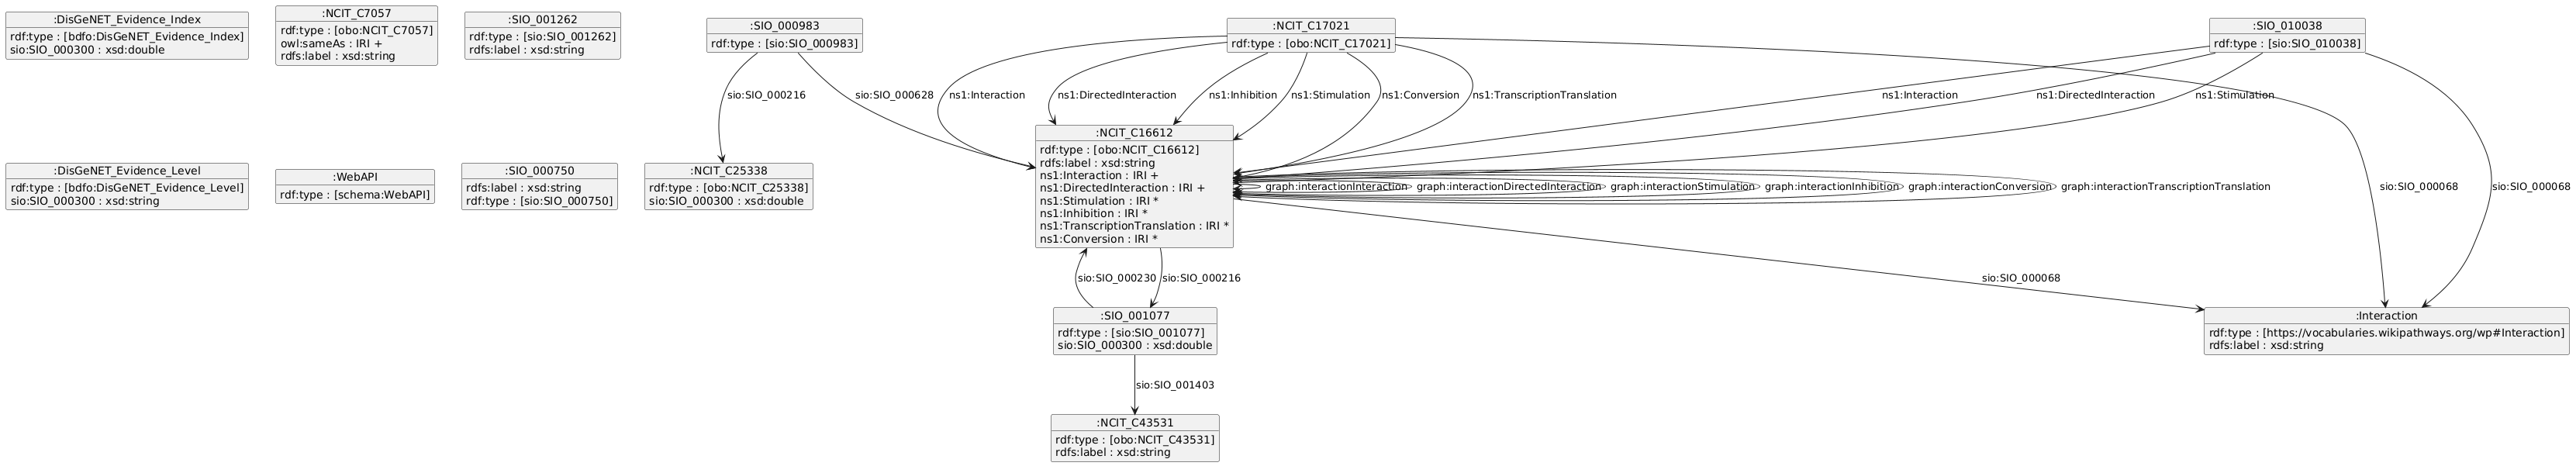

In [48]:
# Use without parameters (defaults)
# bdf.shacl()

# Or use with parameters
bdf.shacl(
    path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shacl.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shacl.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "data",
            "gene_to_graph_workflow",
            "BDF_example_shacl.png",
        )
    )
)

- **ShEx**

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX weso-s: <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX bdfo: <https://biodatafuse.org/onto/bdf#>
PREFIX minerva: <https://minerva-net.lcsb.uni.lu/api/>
PREFIX reactome: <https://reactome.org/content/detail/>
PREFIX uniprot: <https://www.uniprot.org/uniprotkb/>
PREFIX ensembl: <http://identifiers.org/ensembl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX fo

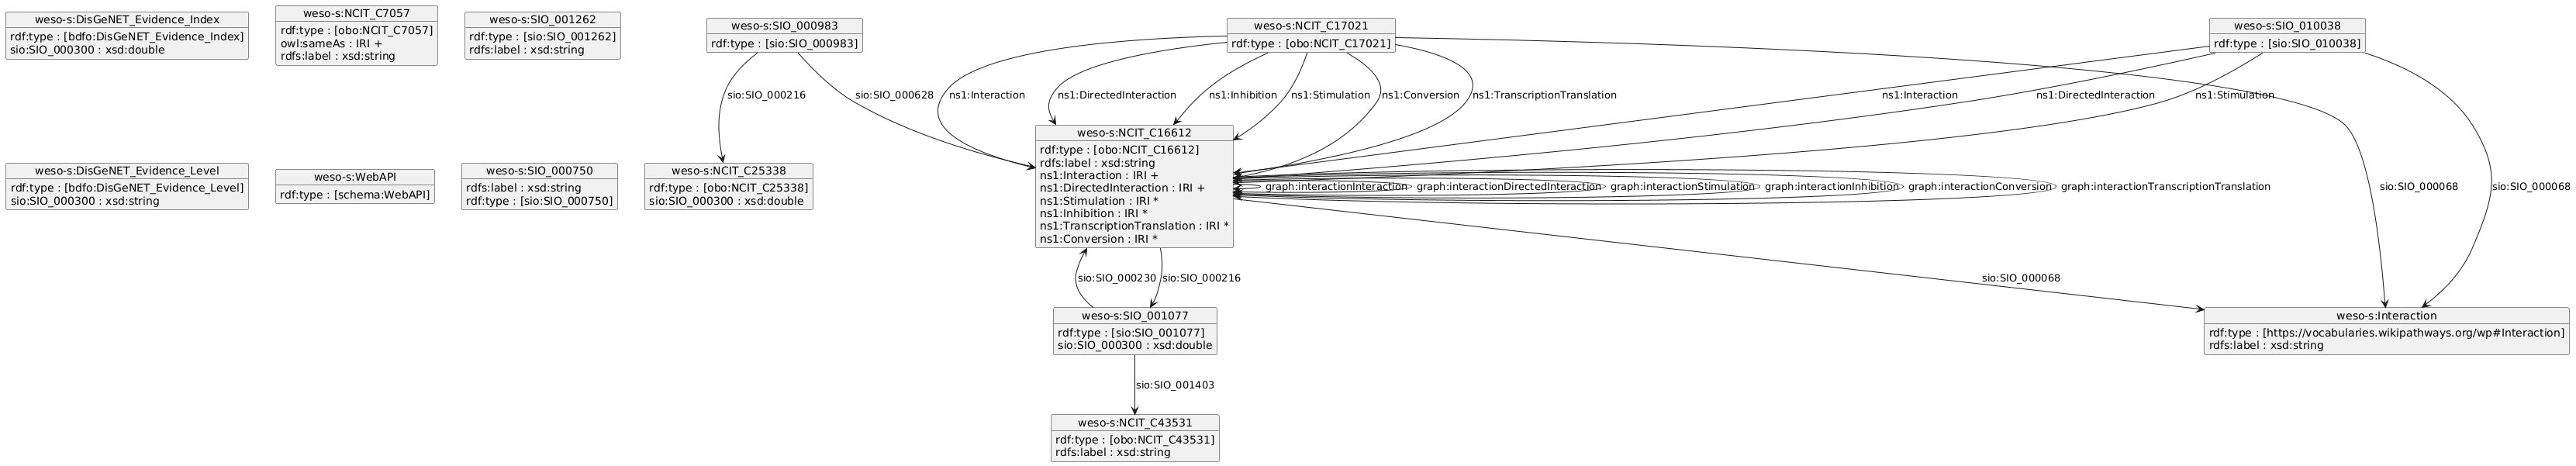

In [49]:
# Use without parameters (defaults)
# bdf.shex()

# Or use with parameters
bdf.shex(
    path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shex.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shex.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "data",
            "gene_to_graph_workflow",
            "BDF_example_shex.png",
        )
    )
)

##### 8.5.3 Set up a GraphDB instance
- Download the latest version of GraphDB from https://graphdb.ontotext.com//
- Run from a direct access or terminal
- Open the GraphDB Workbench in your web browser by navigating to `http://localhost:7200`

The `GraphDBManager` allows you to perform simple operations on the your GraphDB location, such as creating a new repository, deleting a repository, importing RDF data into a repository, querying the loaded graphs and retrieving visualizations. For more advanced operations, you can use the GraphDB Workbench or the GraphDB API.

- Create a new repository

In [50]:
# GraphDB configuration
base_url = "http://localhost:7200"
repository_name = "gene_to_graph_workflow"
username = "admin"
password = "root"

print("Creating repository...")
GraphDBManager.create_repository(base_url, repository_name, username, password)

print("Listing repositories...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)

Creating repository...
Listing repositories...
Repositories: [{'id': 'gene_to_graph_workflow', 'title': 'Gene_to_graph_workflow', 'uri': 'http://pallascat:7200/repositories/gene_to_graph_workflow', 'externalUrl': 'http://pallascat:7200/repositories/gene_to_graph_workflow', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'INACTIVE'}]


- Load the RDF data into the repository

In [51]:
print("Uploading RDF graph to GraphDB...")
GraphDBManager.upload_to_graphdb(
    base_url, repository_name, username, password, bdf, file_format="turtle"
)
print("Counting triples in the repository...")
triple_count = GraphDBManager.count_triples(base_url, repository_name, username, password)
print(f"Triple count: {str(triple_count)}")

Uploading RDF graph to GraphDB...
Counting triples in the repository...
Triple count: {'inferred': 120, 'total': 46161, 'explicit': 46041}


- Load the prefixes SHACL graph into the repository

In [52]:
print("Uploading Prefixes SHACL graph to GraphDB...")
GraphDBManager.upload_to_graphdb(
    base_url,
    repository_name,
    username,
    password,
    bdf.shacl_prefixes(),
)
print("Counting triples in the repository...")
triple_count = GraphDBManager.count_triples(base_url, repository_name, username, password)
print(f"Triple count: {str(triple_count)}")

Uploading Prefixes SHACL graph to GraphDB...
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene_expression_value"^^xsd:anyURI ;
            sh:prefix "gene_expression_value_base_node" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2004/02/skos/core#"^^xsd:anyURI ;
            sh:prefix "skos" ] .

[] sh:declare [ sh:namespace "https://identifiers.org/ensembl:"^^xsd:anyURI ;
            sh:prefix "ensembl" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/interaction"^^xsd:anyURI ;
            sh:prefix "interaction" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2001/XMLSchema#"^^xsd:anyURI ;
            sh:prefix "xsd" ] .

[] sh:declare [ sh:namespace "http://purl.obolibrary.org/obo/so#"^^xsd:anyURI ;
            sh:prefix "so" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/1999/02/22-rdf-syntax-ns#"^^xsd:anyURI ;
            sh:prefix "rd

- Delete the repository

In [53]:
print("Deleting repository...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)
GraphDBManager.delete_repository(base_url, repository_name, username, password)
print("Listing repositories...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)

Deleting repository...
Repositories: [{'id': 'gene_to_graph_workflow', 'title': 'Gene_to_graph_workflow', 'uri': 'http://pallascat:7200/repositories/gene_to_graph_workflow', 'externalUrl': 'http://pallascat:7200/repositories/gene_to_graph_workflow', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'RUNNING'}]
Listing repositories...
Repositories: []
